In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import os

base_path = "../Data/images"

print("Exists?", os.path.exists(base_path))
print("Absolute path:", os.path.abspath(base_path))


Exists? True
Absolute path: c:\Users\Lolo-\OneDrive\سطح المكتب\Sukuk Assighnment\Data\images


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


base_path = r"../Data/images"

# Load pre-trained MobileNetV2 (used for feature extraction)
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224, 224, 3)
)

file_paths, pdf_folders, features = [], [], []

batch_size = 8
batch_imgs = []
batch_meta = []

# Loop through folders and process images in batches
for folder in tqdm(os.listdir(base_path), desc="Processing folders"):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            if len(img.shape) == 2:  # Grayscale image
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            # Resize and convert to RGB
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            batch_imgs.append(img)
            batch_meta.append((img_path, folder))

            # Process each batch
            if len(batch_imgs) == batch_size:
                x = np.array(batch_imgs)
                x = preprocess_input(x)
                batch_feats = base_model.predict(x, verbose=0)

                for i, feat in enumerate(batch_feats):
                    file_paths.append(batch_meta[i][0])
                    pdf_folders.append(batch_meta[i][1])
                    features.append(feat.flatten())

                # Clear memory
                batch_imgs, batch_meta = [], []
                del x, batch_feats

#  Process any remaining images
if batch_imgs:
    x = np.array(batch_imgs)
    x = preprocess_input(x)
    batch_feats = base_model.predict(x, verbose=0)
    for i, feat in enumerate(batch_feats):
        file_paths.append(batch_meta[i][0])
        pdf_folders.append(batch_meta[i][1])
        features.append(feat.flatten())

#  Convert to arrays / dataframe
features = np.array(features)
df = pd.DataFrame({"file_path": file_paths, "pdf_folder": pdf_folders})

print(" Total processed images:", len(df))
print(" Feature matrix shape:", features.shape)

# Save features and metadata
np.save("features.npy", features)
df.to_csv("image_metadata.csv", index=False)
print(" Saved features.npy and image_metadata.csv successfully!")


Processing folders: 100%|██████████| 30/30 [02:59<00:00,  6.00s/it]


 Total processed images: 1179
 Feature matrix shape: (1179, 1280)
 Saved features.npy and image_metadata.csv successfully!


##### KMeans

In [5]:
from sklearn.cluster import KMeans

# Number of clusters = 5 
n_clusters = 5

print(" Running KMeans clustering...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(features)

print(" Cluster distribution:")
print(df["cluster"].value_counts())


 Running KMeans clustering...
 Cluster distribution:
cluster
1    411
3    355
4    210
2    113
0     90
Name: count, dtype: int64


##### KMeans clustering dataset

In [6]:
# Save the mapping between each image and its cluster
output_df = df[["file_path", "pdf_folder", "cluster"]]
output_df.to_csv("cluster_results.csv", index=False, encoding="utf-8-sig")

print(" Cluster results saved to cluster_results.csv")


 Cluster results saved to cluster_results.csv


##### Clusters samples

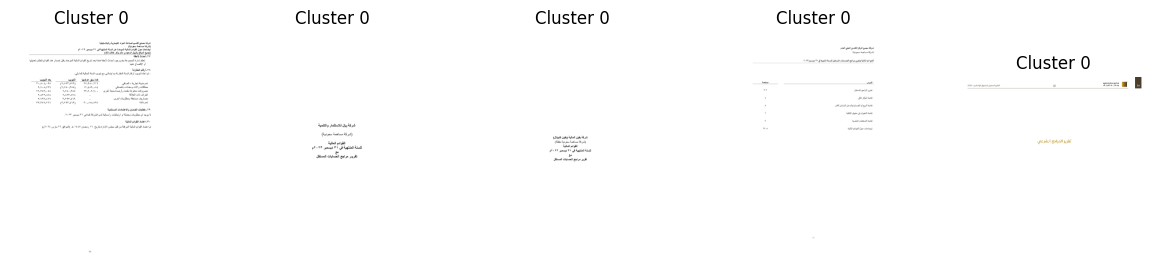

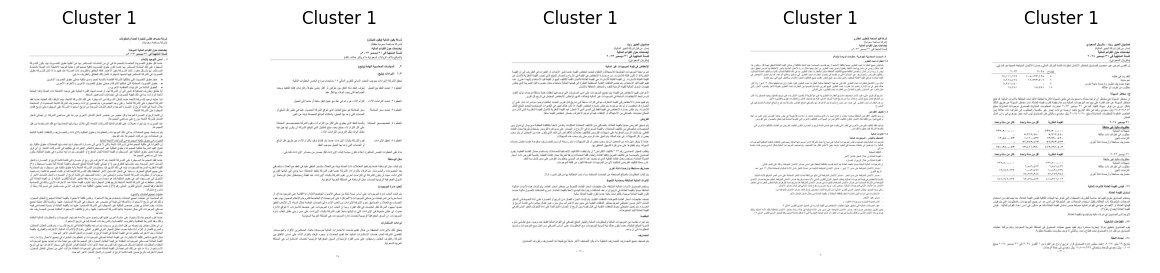

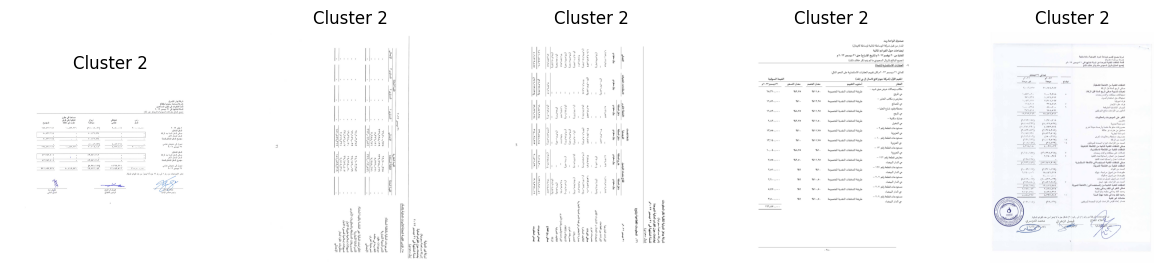

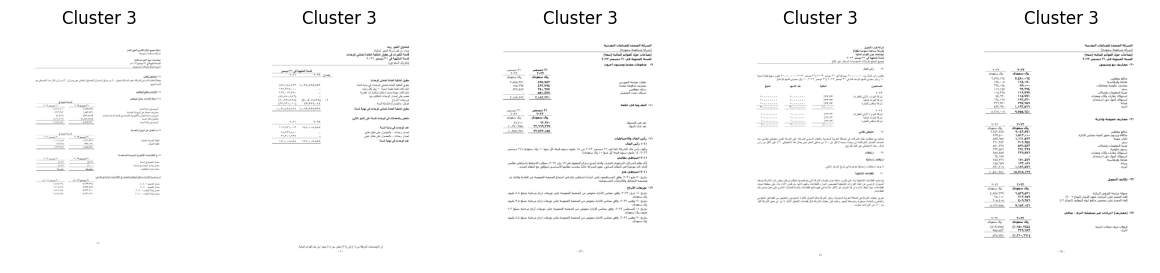

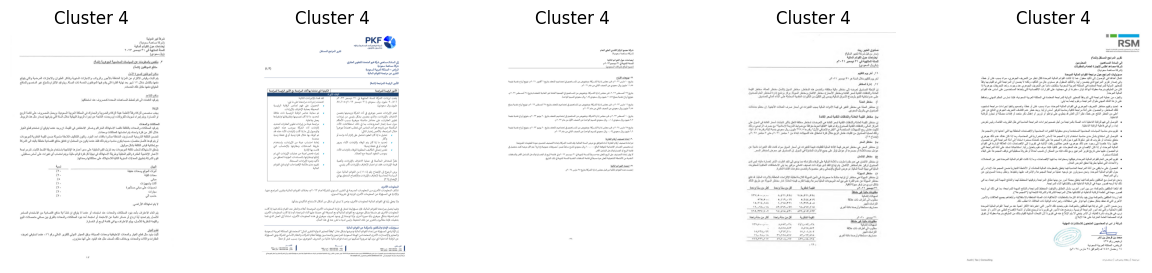

In [ ]:
import matplotlib.pyplot as plt

def show_cluster_samples(cluster_id, n=5):
    subset = df[df["cluster"] == cluster_id]
    if subset.empty:
        print(f"No images found for cluster {cluster_id}")
        return
    
    samples = subset.sample(min(n, len(subset)))
    plt.figure(figsize=(15, 3))
    for i, row in enumerate(samples.itertuples()):
        img = cv2.imread(row.file_path)
        if img is None:
            continue
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Cluster {cluster_id}")
    plt.show()

#  3–5 random images from each cluster
for cid in range(n_clusters):
    show_cluster_samples(cid)


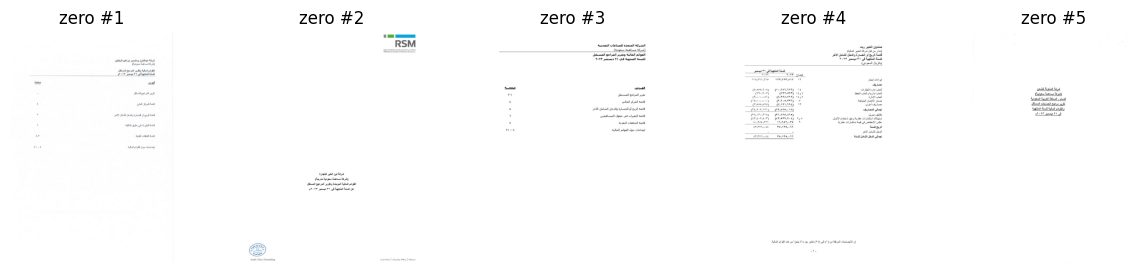

 Displayed 5 random 0 cluster pages


In [8]:
import matplotlib.pyplot as plt
import cv2
import random

# Load the labeled CSV
df = pd.read_csv("cluster_results.csv")

# Filter only rows where cluster == 0
zero_samples = df[df["cluster"] == 0].sample(5, random_state=42)

plt.figure(figsize=(15, 3))
for i, row in enumerate(zero_samples.itertuples()):
    img = cv2.imread(row.file_path)
    if img is None:
        continue
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"zero #{i+1}")
plt.show()

print(" Displayed 5 random 0 cluster pages")


c:\Users\Lolo-\OneDrive\سطح المكتب\Sukuk Assighnment\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


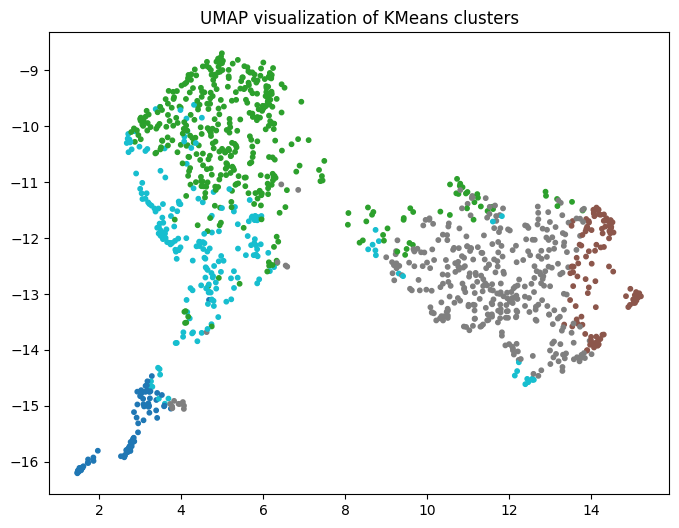

 Saved UMAP 2D features to features_umap.csv


In [10]:
from umap import UMAP
import matplotlib.pyplot as plt

umap_2d = UMAP(n_components=2, random_state=42)
reduced_features = umap_2d.fit_transform(features)

df["umap_x"] = reduced_features[:, 0]
df["umap_y"] = reduced_features[:, 1]

plt.figure(figsize=(8,6))
plt.scatter(df["umap_x"], df["umap_y"], c=df["cluster"], cmap='tab10', s=10)
plt.title("UMAP visualization of KMeans clusters")
plt.show()

df[["file_path", "pdf_folder", "umap_x", "umap_y"]].to_csv("features_umap.csv", index=False)
print(" Saved UMAP 2D features to features_umap.csv")


In [16]:
from sklearn.cluster import DBSCAN

# Range of eps values to test
eps_values = [3, 5, 10, 15, 20, 25, 30]
min_samples = 5

results = []

print(" Testing multiple eps values for DBSCAN...\n")

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(features)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    results.append((eps, n_clusters, n_noise))
    print(f"eps={eps:<3} | clusters: {n_clusters:<3} | noise points: {n_noise}")

 Testing multiple eps values for DBSCAN...

eps=3   | clusters: 0   | noise points: 1179
eps=5   | clusters: 2   | noise points: 911
eps=10  | clusters: 1   | noise points: 65
eps=15  | clusters: 1   | noise points: 9
eps=20  | clusters: 1   | noise points: 5
eps=25  | clusters: 1   | noise points: 0
eps=30  | clusters: 1   | noise points: 0


In [19]:
# Final DBSCAN using eps=10
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=10, min_samples=5)
df["dbscan_cluster"] = dbscan.fit_predict(features)

# Count clusters & noise
n_clusters = len(set(df["dbscan_cluster"])) - (1 if -1 in df["dbscan_cluster"].values else 0)
n_noise = list(df["dbscan_cluster"]).count(-1)

print(" Final DBSCAN results:")
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise}")

df[["file_path", "pdf_folder", "dbscan_cluster"]].to_csv("clusters_dbscan.csv", index=False, encoding="utf-8-sig")
print("Saved DBSCAN results to clusters_dbscan.csv")


 Final DBSCAN results:
Clusters found: 1
Noise points: 65
Saved DBSCAN results to clusters_dbscan.csv


c:\Users\Lolo-\OneDrive\سطح المكتب\Sukuk Assighnment\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


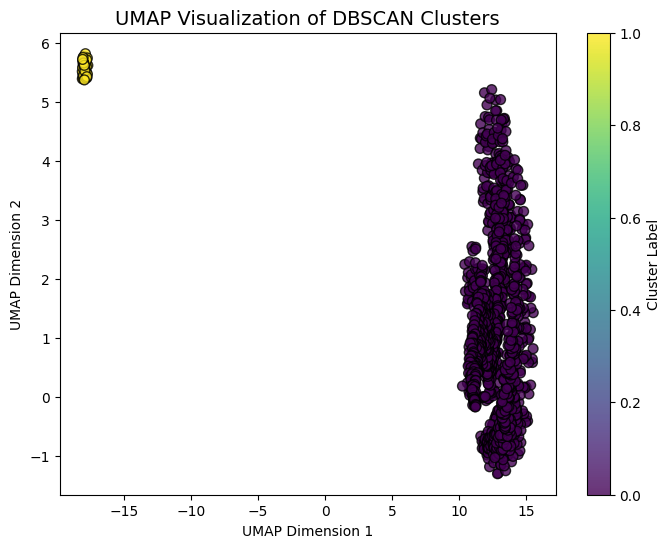

In [14]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

df = pd.read_csv(r"C:\Users\Lolo-\OneDrive\سطح المكتب\Sukuk Assighnment\Modelling\Clustering\Archive\clusters_dbscan.csv")

numeric_df = df.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(X_scaled)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_2d = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=labels, cmap='viridis', s=50, alpha=0.8, edgecolor='k')
plt.title("UMAP Visualization of DBSCAN Clusters", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

c:\Users\Lolo-\OneDrive\سطح المكتب\Sukuk Assighnment\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


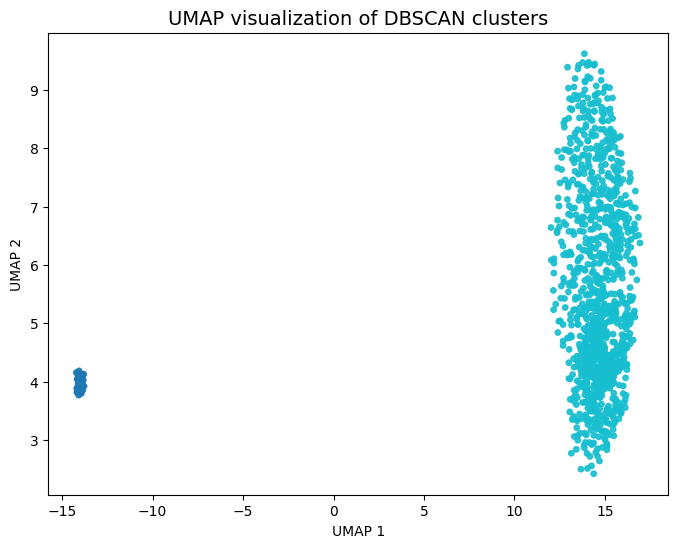

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

df = pd.read_csv(r"C:\Users\Lolo-\OneDrive\سطح المكتب\Sukuk Assighnment\Modelling\Clustering\Archive\clusters_dbscan.csv")

cluster_col = "dbscan_cluster" 
numeric_df = df.select_dtypes(include=[np.number])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_df)

reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
embedding = reducer.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=df[cluster_col],
    cmap='tab10',
    s=15,
    alpha=0.9
)
plt.title("UMAP visualization of DBSCAN clusters", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.show()

In [14]:
print("KMeans clusters:", df["cluster"].nunique())
print("DBSCAN clusters:", df["dbscan_cluster"].nunique())
print("DBSCAN noise points:", sum(df["dbscan_cluster"] == -1))

KMeans clusters: 5
DBSCAN clusters: 1
DBSCAN noise points: 1179


##### I experimented with both K-Means and DBSCAN for unsupervised clustering.
While DBSCAN detected only one dense cluster, K-Means produced five well-separated clusters that aligned with the five target document categories. Therefore, K-Means was selected as the main clustering algorithm.